Total available time per day: 1440 minutes
Average utilization across all days: 82.25%


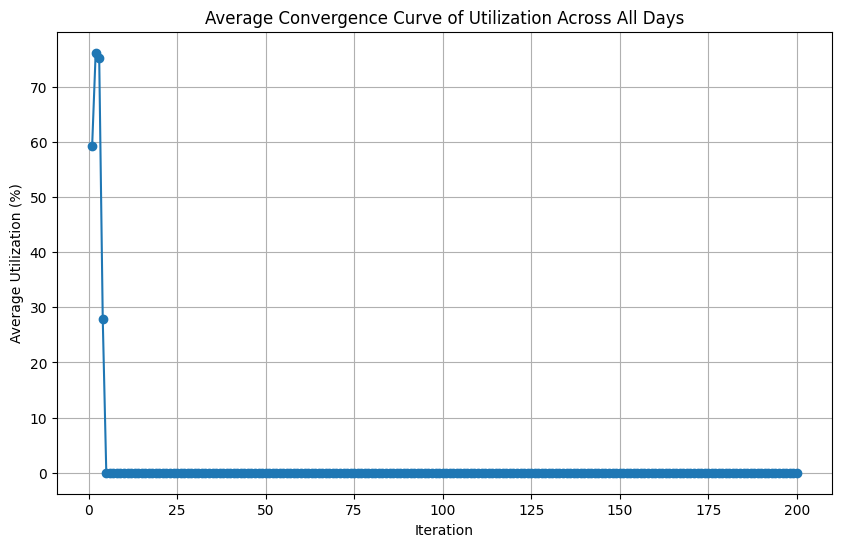

In [49]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset from the Excel file
df_input = pd.read_excel("./Data/Real/DES - Clarity Dental.xlsx", engine='openpyxl',sheet_name='Model_Input')

# Extract the first 9 columns as specified (becauuse there is note there)
df_input_partially = df_input.iloc[:, :9]
df_input_partially.drop(index=df_input_partially.index[-1], axis=0, inplace=True)

class Input_Preprocess:
    def __init__(self, df, num_dentists, num_days, max_working_hours_per_day, max_iterations=200):
        self.df = df
        self.num_dentists = num_dentists
        self.num_days = num_days
        self.max_working_hours_per_day = max_working_hours_per_day
        self.max_iterations = max_iterations

    def processing_format2(self):
        # Calculate the total available time per day for all dentists (in minutes)
        total_available_time_per_day = self.num_dentists * self.max_working_hours_per_day * 60
        total_time_list = []
        convergence_data = np.zeros(self.max_iterations)

        print(f"Total available time per day: {total_available_time_per_day} minutes")

        # Initialize an empty DataFrame to store the simulation results
        simulation_df = pd.DataFrame()

        # Create an empty row to store total hours used each day
        total_hours_row = []

        #Create otal treatment row
        total_treatment = []

        # Loop through each day and simulate the treatment counts
        start_date = datetime.today()
        for i in range(self.num_days):
            current_date = (start_date + timedelta(days=i)).strftime('%Y-%m-%d')
            
            # Step 1 Initial treatment distribution based on Relative Probability with over-allocation
            initial_distribution = np.random.poisson(self.df['Relative Prob'] * 100)  # Further increased
            
            # Step 2 Calculate total time required for this initial distribution
            total_time_required = np.sum(initial_distribution * self.df['Service Time'])
            
            # Step 3 Scale the distribution to fit within the available time
            if total_time_required > total_available_time_per_day:
                scaling_factor = total_available_time_per_day / total_time_required
                adjusted_distribution = np.floor(initial_distribution * scaling_factor).astype(int)
            else:
                adjusted_distribution = initial_distribution
     
            # Step 4 Iteratively adjust to match the available time while ensuring dentist utilization
            iterations = 0
            while not (total_available_time_per_day * 0.8 <= total_time_required <= total_available_time_per_day):
                iterations += 1
                if iterations > self.max_iterations:
                    print(f"Reached max iterations for day {current_date}.")
                    break
                
                remaining_time = total_available_time_per_day - total_time_required
                
                if remaining_time > 0:
                    # Gradually adjust the scaling factor for finer adjustments as we approach the target
                    scaling_factor = 1 + (remaining_time / total_available_time_per_day) * 0.5
                    possible_increase = np.floor((remaining_time / self.df['Service Time']) * scaling_factor)
                    
                    # Handle any potential NaN or infinite values before converting to int
                    possible_increase = possible_increase.replace([np.inf, -np.inf], 0).fillna(0)
                    
                    # Increase treatments based on possible time availability and relative probability
                    adjusted_distribution += np.floor(possible_increase * self.df['Relative Prob']).astype(int)
                
                # Recalculate total time required
                total_time_required = np.sum(adjusted_distribution * self.df['Service Time'])

                # Record the current utilization for the convergence plot
                current_utilization = (total_time_required / total_available_time_per_day) * 100
                if iterations <= self.max_iterations:
                    convergence_data[iterations - 1] += current_utilization  # Sum the utilization for averaging later
                
                # If we exceed available time, scale back
                if total_time_required > total_available_time_per_day:
                    scaling_factor = total_available_time_per_day / total_time_required
                    adjusted_distribution = np.floor(adjusted_distribution * scaling_factor).astype(int)
                    total_time_required = np.sum(adjusted_distribution * self.df['Service Time'])

                    # Check if the total time is within the desired range
                    if total_available_time_per_day * 0.8 <= total_time_required <= total_available_time_per_day:
                        break
            
            # Store the total hours used for the day (convert minutes to hours)
            total_hours_row.append(total_time_required / 60.0)
            total_time_list.append(total_time_required)
            total_treatment.append(adjusted_distribution.sum())
            
            # Add the simulation results to the DataFrame
            simulation_df[current_date] = adjusted_distribution

        # Add the "Code" column to the DataFrame
        simulation_df.insert(0, 'Code', self.df['Code'])

        # Create a Dataframe for total treatment
        total_treatment_df = pd.DataFrame([['total_treatment'] + total_treatment], columns=simulation_df.columns)

        # Create a DataFrame for the total hours row
        total_hours_df = pd.DataFrame([['total_hours'] + total_hours_row], columns=simulation_df.columns)

        df_code_label = simulation_df.iloc[:,:1]
        df_process2 = simulation_df.iloc[:, 1:].astype(float)
        total_treatment_divider = total_treatment_df.iloc[:,1:].astype(float)
        df_process2 = df_process2.div(total_treatment_divider.iloc[0], axis=1)

        final_df = pd.DataFrame()
        final_df = pd.concat([df_code_label, df_process2], axis=1)
        final_df = pd.concat([final_df, total_treatment_df, total_hours_df], ignore_index=True)

        # Calculate and print the average utilization percentage
        average_utilization = (np.mean(total_time_list) / total_available_time_per_day) * 100
        print(f"Average utilization across all days: {average_utilization:.2f}%")

        # Plot the average convergence curve
        avg_convergence_data = convergence_data / self.num_days
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(avg_convergence_data) + 1), avg_convergence_data, marker='o')
        plt.title('Average Convergence Curve of Utilization Across All Days')
        plt.xlabel('Iteration')
        plt.ylabel('Average Utilization (%)')
        plt.grid(True)
        plt.show()

        return final_df
    
    #Add other method later
    
# Instantiate and process the data
processed_data1 = Input_Preprocess(df_input_partially, num_dentists=3, num_days=30, max_working_hours_per_day=8)


# Generate the output DataFrame
output = pd.DataFrame(processed_data1.processing_format2())

# Save the output to a CSV file
# output.to_csv("./Data/Real/Model_Input_Preprocess_v2.csv", index=False)
